In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore


C:\Users\Wilson\AppData\Local\Temp\ipykernel_29648\632085283.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Read data with 'Timestamp'
data = pd.read_csv('result.csv')

# Convert 'seconds' to timedelta and add it to the starting timestamp
data['timestamp'] = pd.to_timedelta(data['Timestamp'], unit='s') + pd.Timestamp('2025-01-02 00:00')


# Set 'timestamp' as the index
data.set_index(keys='timestamp', inplace=True)

data_ffill = data.fillna(method='ffill').dropna()


# Calculate z-scores for bid prices
z_scores = zscore(data_ffill['Ask'])

# Define threshold value
threshold = 1

# Find data points with z-score greater than threshold
outliers_indices = np.where(np.abs(z_scores) > threshold)[0]

# Remove outliers from the DataFrame
cleaned_data = data_ffill.drop(data_ffill.index[outliers_indices])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(cleaned_data['Ask'].values.reshape(-1,1))



C:\Users\Wilson\AppData\Local\Temp\ipykernel_29648\1760278101.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ffill = data.fillna(method='ffill').dropna()


In [4]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]





In [5]:
# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(trainX, trainY, epochs=50, batch_size=128, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to be in the original scale of 'Bid' prices
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Inverting the scaling for the actual values, to have them in the original scale for comparison
trainY_inv = scaler.inverse_transform([trainY])
testY_inv = scaler.inverse_transform([testY])



Epoch 1/50

2018/2018 - 3s - loss: 0.0213 - 3s/epoch - 1ms/step
Epoch 2/50
2018/2018 - 2s - loss: 8.0445e-04 - 2s/epoch - 909us/step
Epoch 3/50
2018/2018 - 2s - loss: 8.0153e-04 - 2s/epoch - 903us/step
Epoch 4/50
2018/2018 - 2s - loss: 8.0121e-04 - 2s/epoch - 920us/step
Epoch 5/50
2018/2018 - 2s - loss: 8.0108e-04 - 2s/epoch - 906us/step
Epoch 6/50
2018/2018 - 2s - loss: 8.0042e-04 - 2s/epoch - 871us/step
Epoch 7/50
2018/2018 - 2s - loss: 7.9993e-04 - 2s/epoch - 868us/step
Epoch 8/50
2018/2018 - 2s - loss: 7.9911e-04 - 2s/epoch - 845us/step
Epoch 9/50
2018/2018 - 2s - loss: 7.9969e-04 - 2s/epoch - 868us/step
Epoch 10/50
2018/2018 - 2s - loss: 7.9852e-04 - 2s/epoch - 884us/step
Epoch 11/50
2018/2018 - 2s - loss: 7.9867e-04 - 2s/epoch - 898us/step
Epoch 12/50
2018/2018 - 2s - loss: 7.9870e-04 - 2s/epoch - 1ms/step
Epoch 13/50
2018/2018 - 2s - loss: 7.9802e-04 - 2s/epoch - 896us/step
Epoch 14/50
2018/2018 - 2s - loss: 7.9854e-04 - 2s/epoch - 894us/step
Epoch 15/50
2018/2018 - 2s - loss:

In [6]:
# Calculate RMSE
trainRMSE = np.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
testRMSE = np.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))

print(f'Train RMSE: {trainRMSE}')
print(f'Test RMSE: {testRMSE}')

# Calculate the time difference between consecutive timestamps
time_diff = data.index.to_series().diff()

# Check if there is a delay between timestamps
delay = time_diff.max()

if delay.total_seconds() > 0:
    print(f"There is a delay of {delay.total_seconds()} seconds between timestamps.")
else:
    print("There is no delay between timestamps.")


Train RMSE: 1.8011850165949874
Test RMSE: 1.3254374532429236
There is a delay of 1.457 seconds between timestamps.


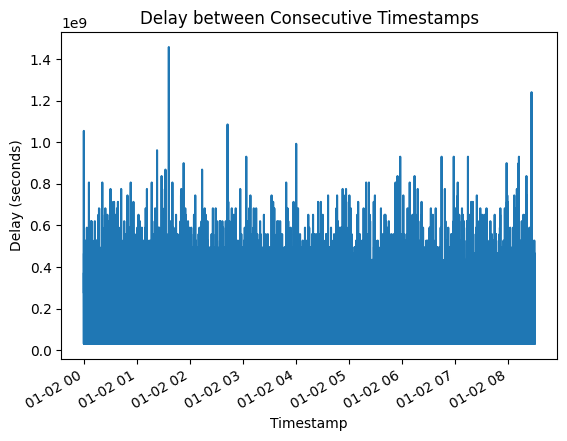

In [7]:
time_diff.plot()
plt.xlabel('Timestamp')
plt.ylabel('Delay (seconds)')
plt.title('Delay between Consecutive Timestamps')
plt.show()


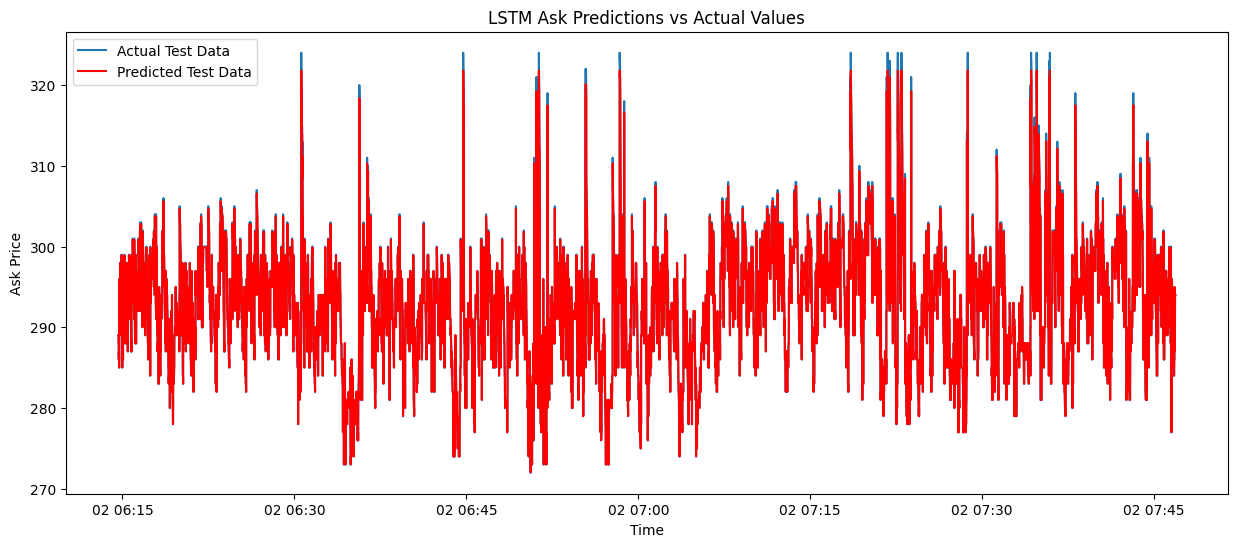

In [8]:
# Plotting
plt.figure(figsize=(15, 6))

# Use the timestamp range corresponding to the test data for x-axis
timestamps = data.index[train_size+look_back:train_size+look_back+len(testPredict)]

plt.plot(timestamps, testY_inv[0], label='Actual Test Data')
plt.plot(timestamps, testPredict.flatten(), label='Predicted Test Data', color='red')
plt.legend()
plt.title('LSTM Ask Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Ask Price')
plt.show()

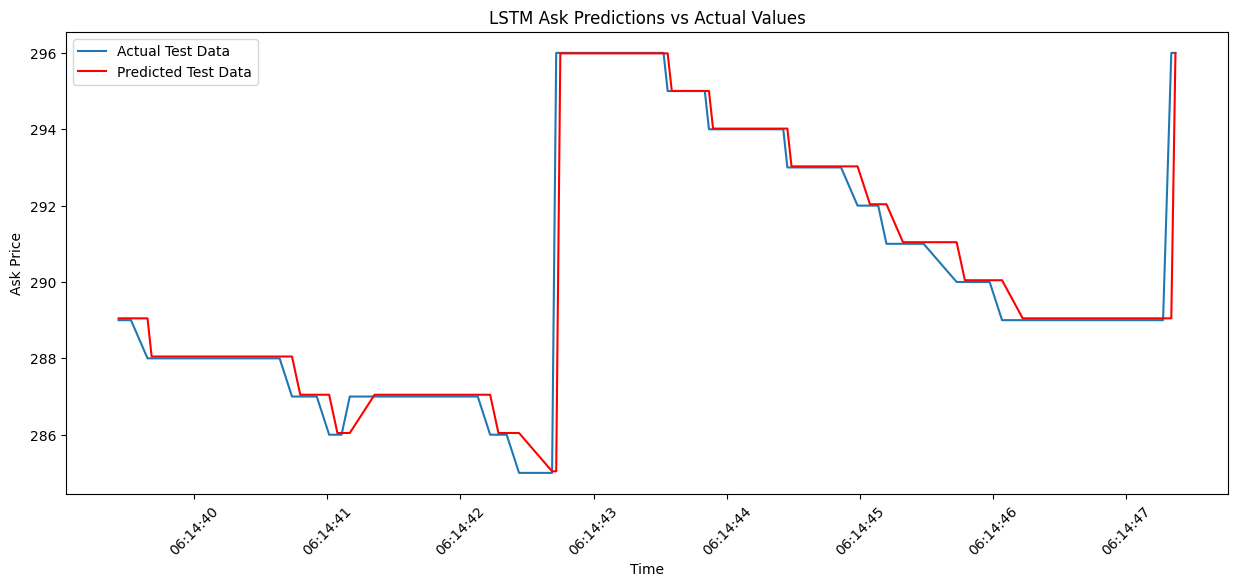

In [13]:
# Select a small number of predicted values to plot
num_values = 100
selected_timestamps = timestamps[:num_values]
selected_testPredict = testPredict[:num_values]
selected_testY_inv = testY_inv[0][:num_values]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(selected_timestamps, selected_testY_inv, label='Actual Test Data')
plt.plot(selected_timestamps, selected_testPredict.flatten(), label='Predicted Test Data', color='red')
plt.legend()
plt.title('LSTM Ask Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Ask Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()
